In [1]:
import numpy as np
from os.path import dirname, join as pjoin

from scipy.misc import derivative
import sys,math
import scipy.io as sio
from scipy.io import readsav

import matplotlib.pyplot as plt 

from PIL import Image as im 

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import copy

In [2]:
font = {'family' : 'Times',
        'size'   : 30}	
plt.rc('font', **font) #set all plot font attributes according to above

In [3]:
def trackPercent(place,totalLength,strLen): #percent output tracker
    percent = place/totalLength*100
    if math.floor(percent)==69:
        string="{:.2f} % complete -- nice".format(percent)
    else:
        string="{:.2f} % complete".format(percent)
    sys.stdout.write("\r") #this "moves the cursor" to the beginning of the I0 line
    sys.stdout.write(" "*strLen) #this "clears" whatever was on the line last time by writing whitespace
    sys.stdout.write("\r") #move the cursor back to the start again
    sys.stdout.write(string) #display the current percent we are at
    sys.stdout.flush() #flush finishes call to print() (this is like what's under the hood of print function)
    strLen=len(string) #return the new string length for next function call
    return strLen

# 1-Parameter Models

## A family of curves to model the apparent kinematics of static streamer strucures in the corona as the PSP flies past them at perihelion 

------------------------------------------------------------------------------------------------------------------

### Fixed along-track distance (aka crossing time): 

### First, we just change the cross-track distance, i.e. the lateral distance from the spacecraft track / perpendicular-to-track distance

H_SW shape:  (20, 4200)   <--- 50 curves, each of [ ] data points equal to num in linspace


<ipython-input-4-f2f263e3c0ce>:23: RuntimeWarning: divide by zero encountered in true_divide
  alt_list.append(np.arctan((h_arr/x))*180./np.pi)


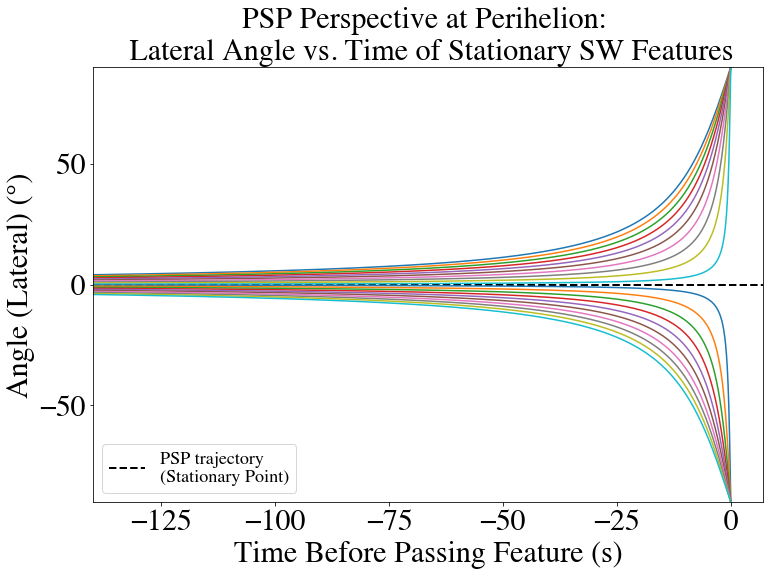

In [4]:
# Analytical Curves, with spacecraft speed set to unity and feature speeds fixed (zero speed)
    
# Number of curves we will examine
n = 20

# "Known" pysical quantities
v_PSP = 1 # km/s 
v_SW = 0 # km/s
x_0 = -140 # km

t_start = 140 # s
time_samples = 4200
H0_range = np.linspace(-10,10,num=n) # km
t = np.linspace(0,t_start,num=time_samples) # s

# Linear kinematic equations for SW features and s/c
H_SW = [H_0 +(v_SW*(t+t_start)) for H_0 in H0_range]
print("H_SW shape: ",(np.array(H_SW)).shape,"  <--- 50 curves, each of [ ] data points equal to num in linspace")
x = x_0 + (v_PSP*(t+t_start)) 
alt_list = []

for h_arr in H_SW:
    alt_list.append(np.arctan((h_arr/x))*180./np.pi)

plt.figure(figsize=(12,8))

for alt in alt_list:
    fig = plt.plot(-t,-alt,linestyle='solid') #,label='Apparent track of SW feature in FOV',color='blue') 

# Plot the results
plt.title("PSP Perspective at Perihelion: \n Lateral Angle vs. Time of Stationary SW Features",fontsize=30)
plt.xlabel("Time Before Passing Feature (s)",fontsize=30)
plt.ylabel("Angle (Lateral) (°)",fontsize=30)

plt.ylim(-90,90)
plt.xlim(-t_start)
plt.hlines(y=0,xmin=-t_start,xmax=10,color='black',linewidth=2,linestyle='--',label="PSP trajectory \n(Stationary Point)")
plt.legend(loc='lower left',fontsize=18)

The above graph shows the altitude of various (stationary) SW features at different lateral distances from the spacecraft track, as seen by PSP. These curves represent apparent motion of the features: It is PSP only that is moving.

No feature actually collides because no feature starts (and therefore stays) on the plane of orbit (as represented by the horizontal black line at altitude = 0 deg). All features eventually diverge from the FOV, but those closest to the spacecraft track show large changes in lateral angle, while those farther away from PSP present slower perspective changes.

### Fixed cross-track distance:

### Next, we vary along-track distances (aka crossing times)

<ipython-input-5-fe0c249dbf17>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
<ipython-input-5-fe0c249dbf17>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
<ipython-input-5-fe0c249dbf17>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
<ipython-input-5-fe0c249dbf17>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
<ipython-input-5-fe0c249dbf17>:24: RuntimeWarning: divide by zero encountered in true_divide
  alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)


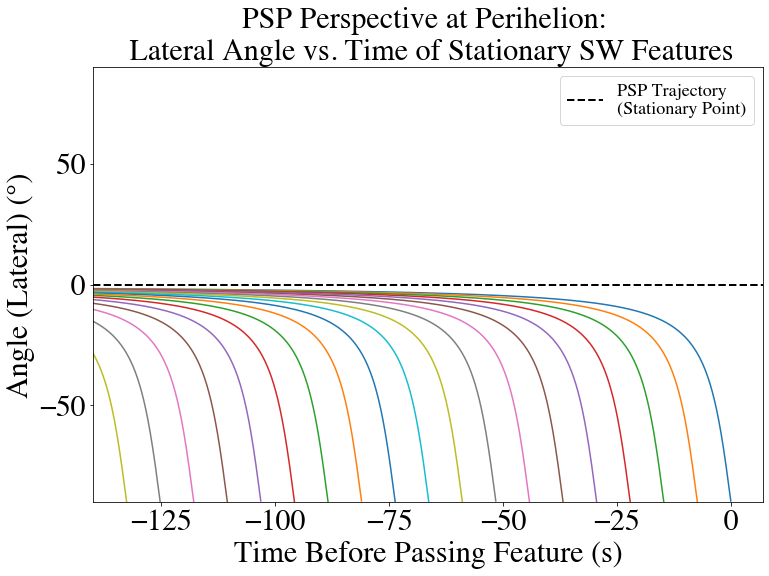

In [5]:
NCurves = 20

# "Known" pysical quantities
v_PSP = 1 # km/s 
v_SW = 0 # km/s
x_0 = -140 # km

t_total = 140 # s
time_samples = 4200

h0 = 4

##
time_array = np.linspace(0,t_total,time_samples)
x_PSP = v_PSP*time_array

h0 = 4
cross_times = np.linspace(0,140,NCurves)
alt_list = np.zeros((len(cross_times),time_samples))

plt.figure(figsize=(12,8))
for curve in range(NCurves):
    cross_time_arr = time_array - cross_times[curve] # v_PSP = 1
    alt_list[curve] = (np.arctan((h0/cross_time_arr))*180./np.pi)
    alt_list_to_plot = alt_list[curve]
    alt_list_to_plot = alt_list_to_plot[time_array > cross_times[curve]]
    plt.plot(-t[time_array > cross_times[curve]],-alt_list_to_plot,linestyle='solid') 
    
    

# Plot the results
plt.title("PSP Perspective at Perihelion: \n Lateral Angle vs. Time of Stationary SW Features",fontsize=30)
plt.xlabel("Time Before Passing Feature (s)",fontsize=30)
plt.ylabel("Angle (Lateral) (°)",fontsize=30)
plt.ylim(-90,90)
plt.xlim(-t_start)
plt.hlines(y=0,xmin=-t_start,xmax=10,color='black',linewidth=2,linestyle='--',label="PSP Trajectory \n(Stationary Point)")
plt.legend(loc='upper right',fontsize=18)




# 2-Parameter Model:

## Arbitrary Collection of Curves (various cross-track distances and along-track distances)

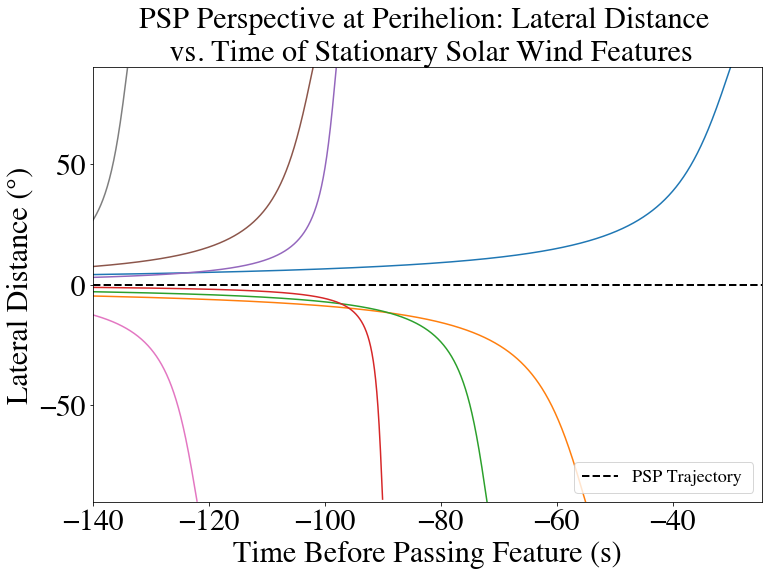

In [270]:
NCurves = 20

# "Known" pysical quantities
v_PSP = 1 # km/s 
v_SW = 0 # km/s
x_0 = -140 # km

t_total = 140 # s
time_samples = 4200

h0 = 4

##
time_array = np.linspace(0,t_total,time_samples)
x_PSP = v_PSP*time_array

cross_times = [30,55,72,90,98,102,122,134,138]
heights = [-8,7,3.5,1,-2.2,-5,4,-3]
alt_list = np.zeros((len(cross_times),time_samples))

plt.figure(figsize=(12,8))
for height in range(len(heights)):
    cross_time_arr = time_array - cross_times[height] # v_PSP = 1
    alt_list[height] = (np.arctan((heights[height]/cross_time_arr))*180./np.pi)
    alt_list_to_plot = alt_list[height]
    alt_list_to_plot = alt_list_to_plot[time_array > cross_times[height]]
    plt.plot(-t[time_array > cross_times[height]],-alt_list_to_plot,linestyle='solid') 
    
    

# Plot the results
plt.title("PSP Perspective at Perihelion: Lateral Distance \n vs. Time of Stationary Solar Wind Features",fontsize=30)
plt.xlabel("Time Before Passing Feature (s)",fontsize=30)
plt.ylabel("Lateral Distance (°)",fontsize=30)
plt.ylim(-90,90)
plt.xlim(-t_start)
plt.hlines(y=0,xmin=-t_start,xmax=10,color='black',linewidth=2,linestyle='--',label="PSP Trajectory ")
plt.legend(loc='lower right',fontsize=18)


# Load Synthetic Streamer Model and Make T-Maps:

### A T-Map is when you take a slice of latitude at a given/specified longitude for every image in the image cube and stack these slices of latitude in time

--------------------------------------------------
Date: Fri Apr 23 17:55:50 2021
User: pliewer_jpl
Host: pcliewer15mbp.charter.com
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2.1
--------------------------------------------------
Successfully read 9 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 6 are of type VARIABLE
--------------------------------------------------
Available variables:
 - nsteps [<class 'numpy.int16'>]
 - nskip [<class 'numpy.int16'>]
 - jsteps [<class 'numpy.int16'>]
 - res [<class 'numpy.int16'>]
 - imgcube [<class 'numpy.ndarray'>]
 - rhocube [<class 'numpy.ndarray'>]
--------------------------------------------------
(42, 256, 512)
height of jmap:  256
width of jmap:  42


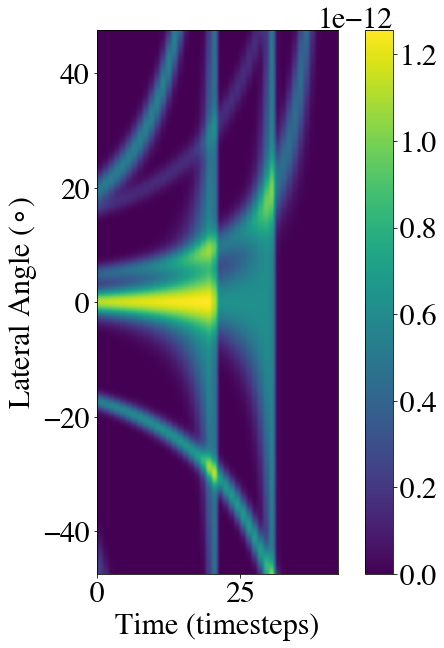

In [276]:
###### Render the jmap

dirname = '/Users/mkenny/Documents/PSP/StreamerModelMeganB/'
sav_fname = pjoin(dirname, 'cubestreamerspporbMeganB.sav')
sav_data = readsav(sav_fname,verbose='True')
imgcube = sav_data['imgcube']
print(imgcube.shape)

# T-map
lat_arr = imgcube[:,:,400] # For a given longitude (in the middle of the image)
tmap = np.transpose(lat_arr, (1,0))
print("height of jmap: ",tmap.shape[0])
print("width of jmap: ",tmap.shape[1])

plt.figure(figsize=(10,10))
plt.imshow(tmap,origin='lower', aspect=1, extent=(0,timesteps_tmap,-95/2.,95/2.))

plt.ylabel('Lateral Angle ($\circ$)')
plt.xlabel('Time (timesteps)')
#plt.title('Lat-map for Static Streamer Model')
ax = plt.colorbar()
fig.savefig('tmap_out.png', bbox_inches='tight', pad_inches=0)



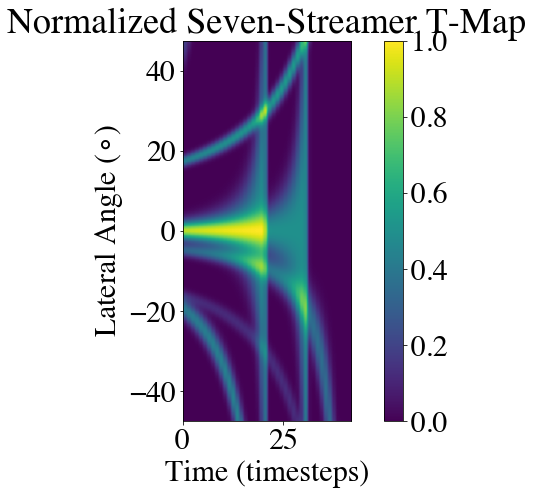

In [278]:
fig = plt.figure(figsize=(12,7)) 
plt.imshow(tmap/np.max(tmap),extent=(0,timesteps_tmap,-95/2.,95/2.))

plt.ylabel('Lateral Angle ($\circ$)')
plt.xlabel('Time (timesteps)')
plt.title('Normalized Seven-Streamer T-Map')
ax = plt.colorbar()
fig.savefig('tmap_out.png', bbox_inches='tight', pad_inches=0)

In [267]:
filepath = '/Users/mkenny/Documents/PSP/StreamerModelMeganB/streamerspporb_MeganB.txt'
textfile = np.loadtxt(filepath, skiprows=15)


In [269]:
print(textfile.shape)

(42, 6)


In [290]:
print("Number of strands: ",number_of_strands)
print("x, z box sizes: %f, %f"%(x_box_size,z_box_size))

stxarr = strand_params[2:9]
stzarr = strand_params[9:16]

print("\nx angle (on solar surface): ",stxarr)

print("\nz angle (on solar surface): ",stzarr)

Number of strands:  7
x, z box sizes: 0.600000, 0.200000

x angle (on solar surface):  [1.4922565 1.6493361 1.3437458 1.7915735 1.6255139 1.3524284 1.288579 ]

z angle (on solar surface):  [1.5707964 1.5707964 1.4913814 1.6381266 1.5165703 1.5469663 1.6619055]


In [247]:
'''
Here I compute the inner product of the image (of the analytic curve) and the tmap and fill each pixel
of the output image- the tomogram- with the inner product that corresponds to the the unique parameter pair
''' 

x0_param = np.linspace(0.1,timesteps_tmap,num=100) # along track distance (start at 0.1 to avoid dividing by zero)

# concatenate two arrays so that we don't include VERY small cross-track distance parameter values
h0_param_neg = np.linspace(-20,-0.5, num = 60)
h0_param_pos = np.linspace(0.5,20,num=60) # cross-track distance
h0_param = np.concatenate((h0_param_neg,h0_param_pos))

tomogram_array = np.zeros((len(h0_param),len(x0_param)))
selected_angular_span = 95


str_len = 0
for x in range(len(x0_param)-1):
    for y in range(len(h0_param)-1):
        #print(x,y,x0_param[x],h0_param[y])
        # reset sum each each we eval a new combination of x0, h0
        x0_h0_pixel_sum = 0 
        
        # make an output image (the tomogram) to fill
           # This output image doesn't have to be the same size as the tmap and image curve
              # The sizes of the parameter arrays determine the size of the tomogram
                        
        #  
        '''epsilon = 0.001 # define epsilon
        GS_vector = GS_orthogalization(h0_param[y], x0_param[x], epsilon) # call function to tweak original BF
'''
        image_curve_2d = imgcurves_2d(h0_param[y], x0_param[x],2)
        
        img_tmap_product = tmap*image_curve_2d
        x0_h0_pixel_sum = np.sum(img_tmap_product)
        
        
        # Once done looping through pixels in tmap and image curve image, fill the tomogram pixel w/ porduct-integral
        #print(type(running_sum))
        
        #print("x, y, x0[x], h0[y],running sum: ",x,y,x,h0_param[y],x0_h0_pixel_sum)
        
        tomogram_array[y,x] = x0_h0_pixel_sum
        
        str_len = trackPercent(x,len(x0_param),str_len)
      

[-20.         -19.66949153 -19.33898305 -19.00847458 -18.6779661
 -18.34745763 -18.01694915 -17.68644068 -17.3559322  -17.02542373
 -16.69491525 -16.36440678 -16.03389831 -15.70338983 -15.37288136
 -15.04237288 -14.71186441 -14.38135593 -14.05084746 -13.72033898
 -13.38983051 -13.05932203 -12.72881356 -12.39830508 -12.06779661
 -11.73728814 -11.40677966 -11.07627119 -10.74576271 -10.41525424
 -10.08474576  -9.75423729  -9.42372881  -9.09322034  -8.76271186
  -8.43220339  -8.10169492  -7.77118644  -7.44067797  -7.11016949
  -6.77966102  -6.44915254  -6.11864407  -5.78813559  -5.45762712
  -5.12711864  -4.79661017  -4.46610169  -4.13559322  -3.80508475
  -3.47457627  -3.1440678   -2.81355932  -2.48305085  -2.15254237
  -1.8220339   -1.49152542  -1.16101695  -0.83050847  -0.5
   0.5          0.83050847   1.16101695   1.49152542   1.8220339
   2.15254237   2.48305085   2.81355932   3.1440678    3.47457627
   3.80508475   4.13559322   4.46610169   4.79661017   5.12711864
   5.45762712   5.7

(120, 100)


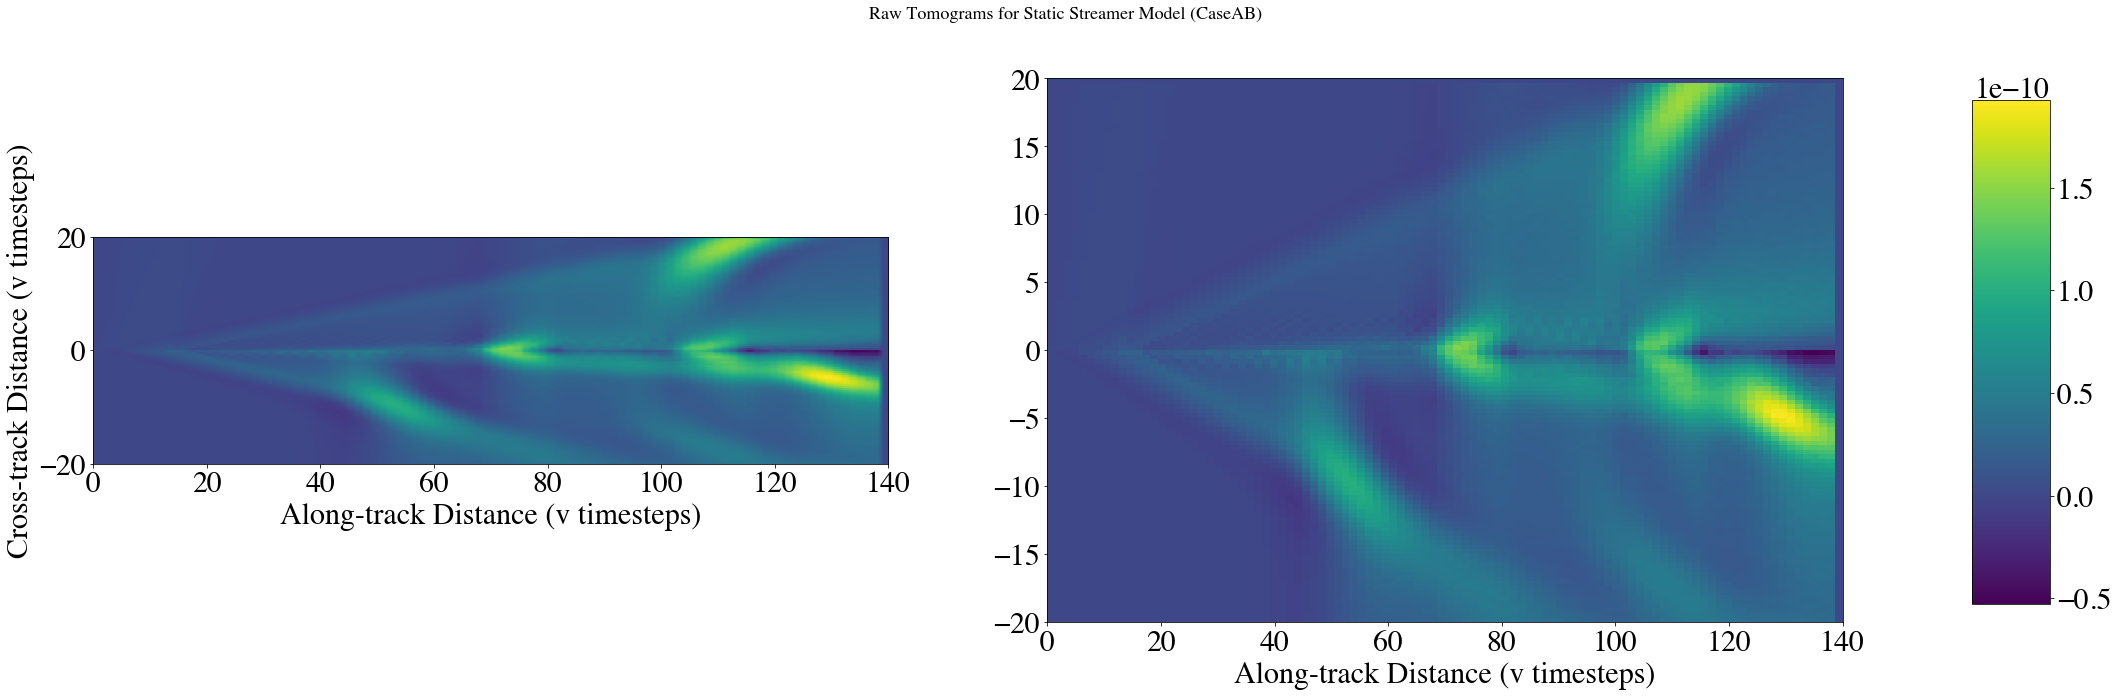

In [248]:
print(tomogram_array.shape)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(36,10))
ax1.imshow(tomogram_array,origin='lower',extent=(0,140,h0_param[0],h0_param[-1],))
zoomed_in = ax2.imshow(tomogram_array,origin='lower',aspect='auto',extent=(0,140,h0_param[0],h0_param[-1],))


ax1.set_xlabel('Along-track Distance (v timesteps)')
ax2.set_xlabel('Along-track Distance (v timesteps)')

ax1.set_ylabel('Cross-track Distance (v timesteps)')
fig.suptitle('Raw Tomograms for Static Streamer Model (CaseAB)',fontsize=18)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(zoomed_in,cax=cbar_ax)

# Previous tomogram below--diagonal rays from bright spots are strong/obvious

In [408]:
tomo = np.copy(tomogram_array)
tomo = 100*tomo/np.max(tomo)
dx = 30; dy = 30

#output = np.zeros((inner_FOV_images,1024,960,2*dy+1,2*dx+1)) # Initialize output array
S2 = np.ones((100-2*dy, 140-2*dx, 2*dy+1, 2*dx+1))
print(S2.shape, tomo.shape[1]+1-2*dx)


# results = [(i, j)
#            for i in range(10)
#            for j in range(i)]
S2 = []
S2 = [(tomo[y,x] - tomo[y + dy_value, x + dx_value])**2
     for y in range(dy, tomo.shape[0] - dy)
     for x in range(dx, tomo.shape[1] - dx)
     for dy_value in range(-dy, dy+1, 1)
     for dx_value in range(-dx, dx+1, 1)]


'''for y in range(dy, tomo.shape[0] - dy): # step through y pixels, shrunk by dy on each end

    for x in range(dx, tomo.shape[1] - dx): # step through x pixels, shrunk by dx on each end

        for dy_value in range(-dy, dy+1, 1):  # step through y lags 
            
            for dx_value in range(-dx, dx+1, 1):  # step through x lags
                #print("x, y, dx, dy, x+dx, y+dy: ",x,y,dx_index, dy_index,x+dx_index, y+dy_index)

#                 print(dy_value, dx_value)
                ## Compute S2, where we square the difference between the image and the shifted image

                S2[y-dy,x-dx,dy_value+dy,dx_value+dx] = (tomo[y,x] - tomo[y + dy_value, x + dx_value])**2
                
#                 if dx_value == 0 and dy_value == 0:
#                     print(x, y, dx_value, dy_value, S2[y-2*dy,x-2*dx,dy_value,dx_value])
                    
                    #print("x = %d, y = %d, x + dx = %d, y+dy = %d"%(x, y, x + dx_value ,y + dy_value, ))
                    '''

(40, 80, 61, 61) 81


'for y in range(dy, tomo.shape[0] - dy): # step through y pixels, shrunk by dy on each end\n\n    for x in range(dx, tomo.shape[1] - dx): # step through x pixels, shrunk by dx on each end\n\n        for dy_value in range(-dy, dy+1, 1):  # step through y lags \n            \n            for dx_value in range(-dx, dx+1, 1):  # step through x lags\n                #print("x, y, dx, dy, x+dx, y+dy: ",x,y,dx_index, dy_index,x+dx_index, y+dy_index)\n\n#                 print(dy_value, dx_value)\n                ## Compute S2, where we square the difference between the image and the shifted image\n\n                S2[y-dy,x-dx,dy_value+dy,dx_value+dx] = (tomo[y,x] - tomo[y + dy_value, x + dx_value])**2\n                \n#                 if dx_value == 0 and dy_value == 0:\n#                     print(x, y, dx_value, dy_value, S2[y-2*dy,x-2*dx,dy_value,dx_value])\n                    \n                    #print("x = %d, y = %d, x + dx = %d, y+dy = %d"%(x, y, x + dx_value ,y + dy_value, ))\

In [412]:
tomo = np.copy(tomogram_array)
tomo = 100*tomo/np.max(tomo)
dx = 30; dy = 30

#output = np.zeros((inner_FOV_images,1024,960,2*dy+1,2*dx+1)) # Initialize output array
S2 = np.ones((100-2*dy, 140-2*dx, 2*dy+1, 2*dx+1))
print(S2.shape, tomo.shape[1]+1-2*dx)

for y in range(dy, tomo.shape[0] - dy): # step through y pixels, shrunk by dy on each end

    for x in range(dx, tomo.shape[1] - dx): # step through x pixels, shrunk by dx on each end

        for dy_value in range(-dy, dy+1, 1):  # step through y lags 
            
            for dx_value in range(-dx, dx+1, 1):  # step through x lags
                #print("x, y, dx, dy, x+dx, y+dy: ",x,y,dx_index, dy_index,x+dx_index, y+dy_index)

#                 print(dy_value, dx_value)
                ## Compute S2, where we square the difference between the image and the shifted image

                S2[y-dy,x-dx,dy_value+dy,dx_value+dx] = (tomo[y,x] - tomo[y + dy_value, x + dx_value])**2
                
#                 if dx_value == 0 and dy_value == 0:
#                     print(x, y, dx_value, dy_value, S2[y-2*dy,x-2*dx,dy_value,dx_value])
                    
                    #print("x = %d, y = %d, x + dx = %d, y+dy = %d"%(x, y, x + dx_value ,y + dy_value, ))
                    

(40, 80, 61, 61) 81


In [411]:
print(np.array(S2).shape)

(11907200,)


(40, 80, 61, 61)
(61, 61)


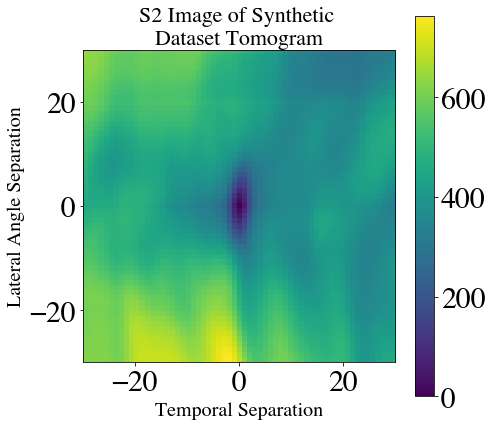

In [414]:
output = np.array(S2)
print(output.shape)
# mean_im = np.mean(output[:-dy-1,:-dx-1,:,:],axis=(0,1))
mean_im = np.mean(output,axis=(0,1))
plt.figure(figsize=(7,7))
plt.imshow(mean_im,origin='lower',extent=(-dx,dx,-dy,dy))
plt.colorbar()

plt.xlabel("Temporal Separation",fontsize=20)
plt.ylabel("Lateral Angle Separation",fontsize=20)
plt.title("S2 Image of Synthetic \nDataset Tomogram",fontsize=22)
 
print(mean_im.shape)

<ipython-input-369-fe77e36a4c38>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


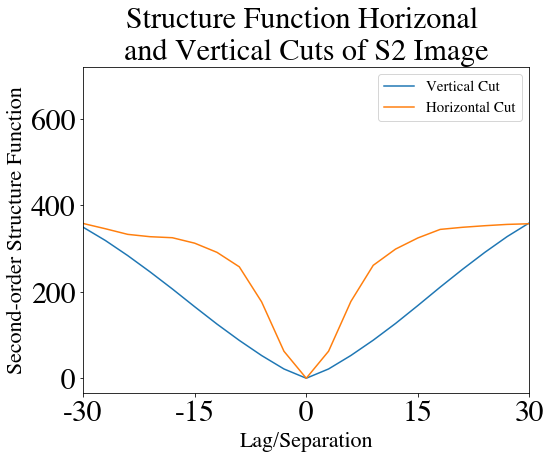

In [369]:
#plt.plot(np.mean(mean_im, axis=1))
#plt.plot(np.mean(mean_im, axis=0))
fig,ax = plt.subplots(figsize=(8,6))

# plt.hlines(380,0,2*dx+1,color='red',linestyle='--')
# plt.hlines(366, 0,2*dx+1,color='red',linestyle='--')
ax.plot(mean_im[:,dx], label='Vertical Cut')
ax.plot(mean_im[dy,:],label='Horizontal Cut')
ax.set_xlabel("Lag/Separation",fontsize=22)
ax.set_ylabel("Second-order Structure Function",fontsize=22)
ax.set_title("Structure Function Horizonal \nand Vertical Cuts of S2 Image",fontsize=30)
fig.canvas.draw()

labels = ['-30','-15','0','15','30']
ax.set_xticklabels(labels) 

plt.xlim(20,40)
plt.legend(fontsize=15)

(90, 130, 11, 11)
307.697444152871


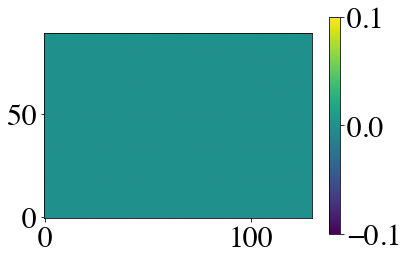

In [286]:
# plt.imshow(output[:-dy-1,:-dx-1,0,0],origin='lower')
plt.imshow(output[:,:,dy,dx],origin='lower')
plt.colorbar()
print(output.shape)
print(np.mean(output[:-dy-1,:-dx-1,0,0]))

new_arr = []
for i in range(2*dy+1):
    for j in range(2*dx+1):
        diff_i = dy - i
        #print(i, diff_i)
        #new_arr.append(output[:,:,i+,j])

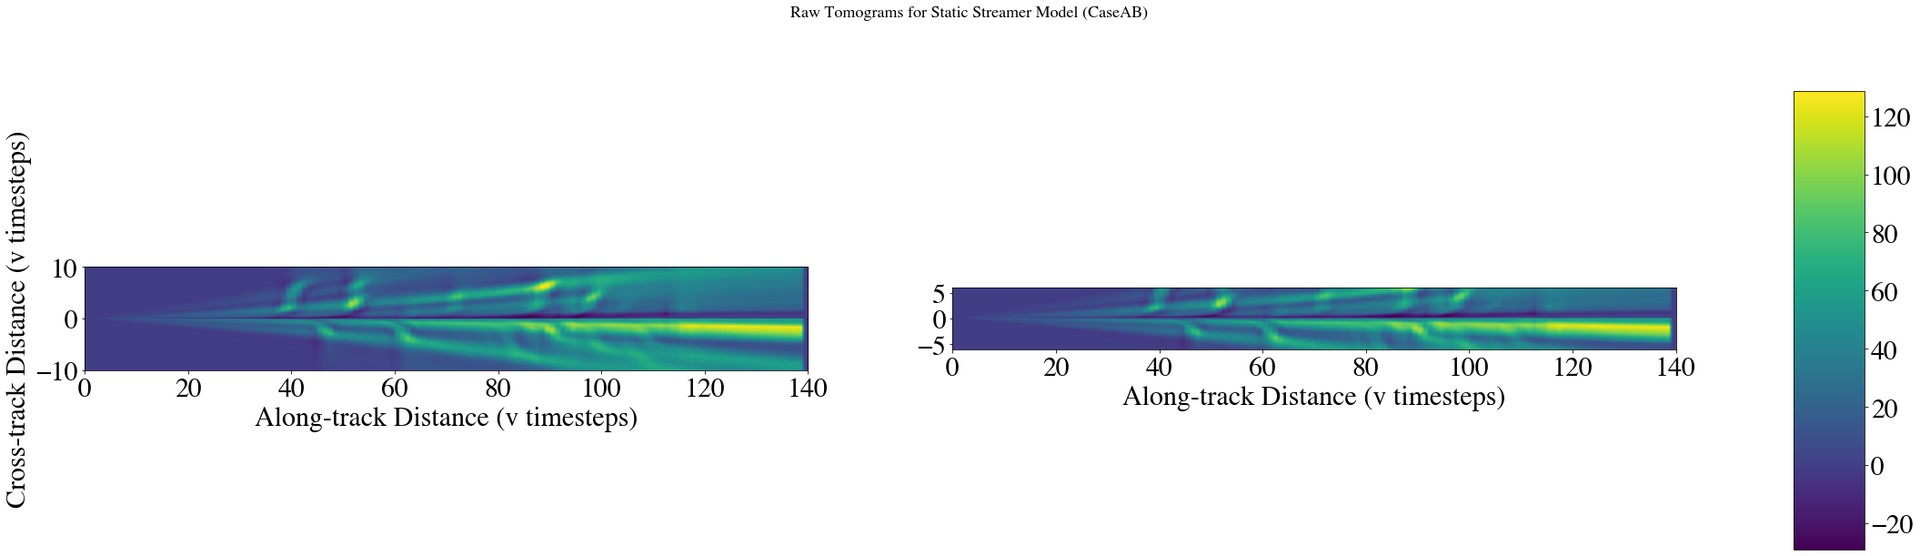

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(tomogram_array,origin='lower',extent=(0,140,h0_param[0],h0_param[-1],))


In [ ]:
tomogram_pixel_sum = np.sum(tomogram_array)
print(tomogram_pixel_sum)
sub_mean= tomogram_array - np.mean(tomogram_array)
plt.imshow(sub_mean,origin='lower',aspect='auto',extent=(0,140,h0_param[0],h0_param[-1],))



## Below: tomogram generated by supressing horizontal region of the basis function

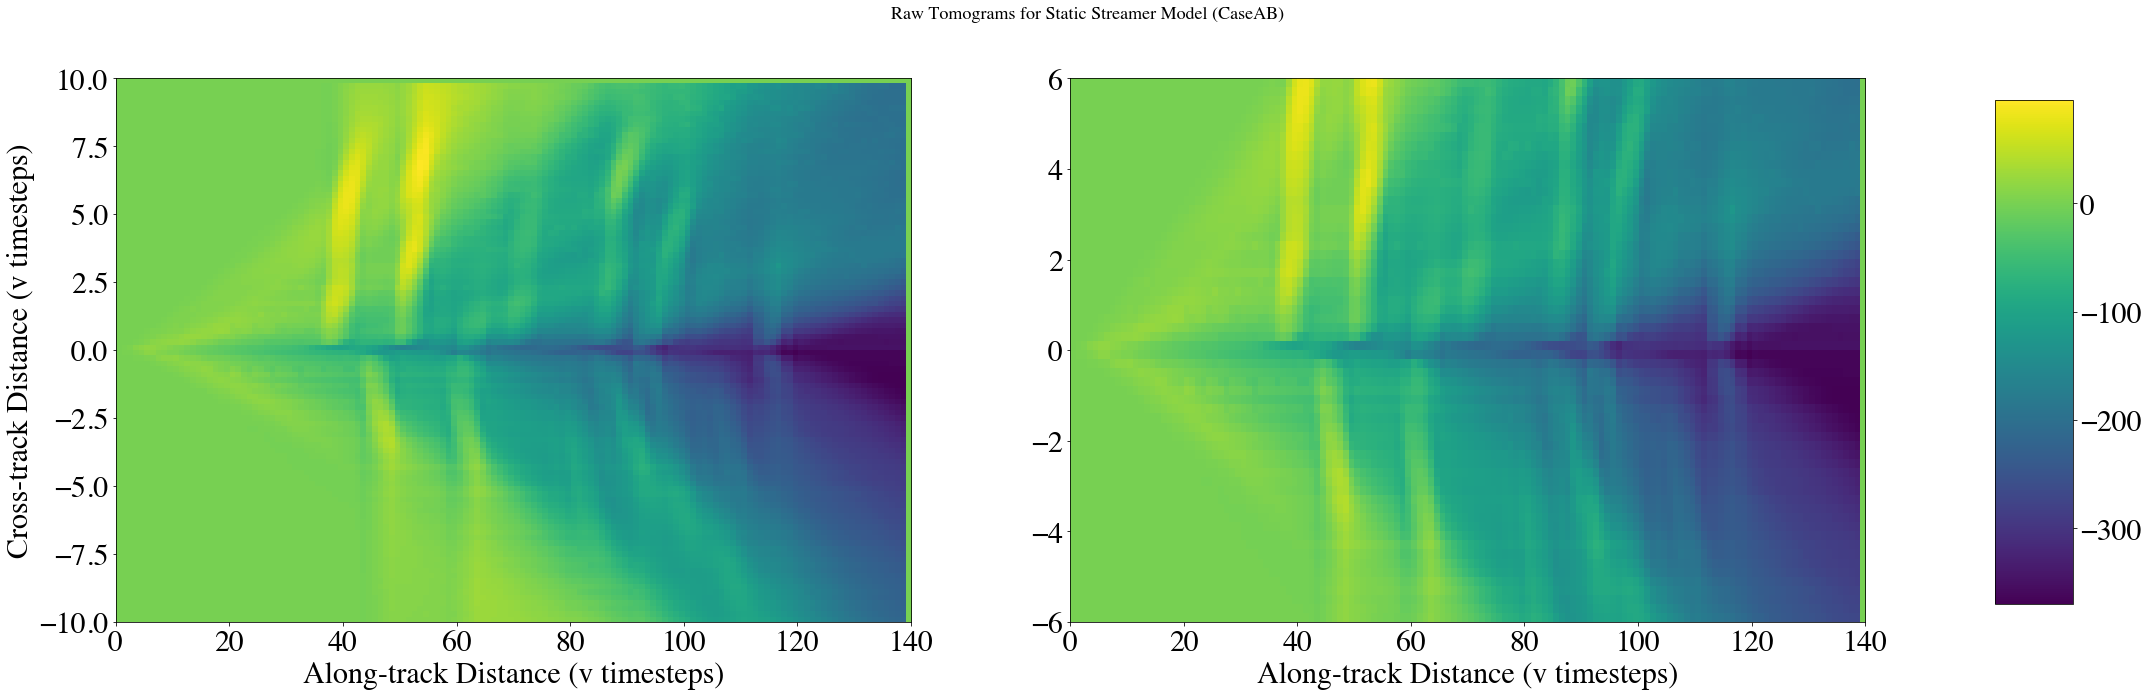

In [ ]:
# Extra code to keep around just in case...
      
                
                        
                '''if x > 0 and yposPlot < ImageYdim and ypos != ycoord_old and xpos != xcoord_old:
                    print(ypos, xpos, ycoord_old, xcoord_old)
                    xindices.append(xpos)
                    yindices.append(ypos)
                    local_deriv = (ypos - ycoord_old)/(xpos - xcoord_old)
                    print(local_deriv)
                    if xpos > xindices[0]:
                        print(xpos,xindices)
                        xposPlot = xpos + j - int(HalfLineWidth)
                        image_data_2d[-yposPlot,xposPlot] = 1'''
                
                # Immediate neighborhood
                '''if yposPlot_plus + HalfLineWidth < ImageYdim and yposPlot_minus > 0:
                    if yposPlot - HalfLineWidth >= 0:
                        if yposPlot_plus <= yposPlot_plus + HalfLineWidth:
                            if yposPlot_minus >= yposPlot_minus - HalfLineWidth:
                                image_data_2d[-(yposPlot_plus + int(HalfLineWidth)), xpos] = 0
                                image_data_2d[-(yposPlot_plus - int(HalfLineWidth)), xpos] = 0
                '''                
                        

                    
### 2-pixel negative band
            # never need these
                '''elif image_data_2d[ystep,xstep+2] == 0:
                    image_data_2d[ystep,xstep] = -1
                elif image_data_2d[ystep+2,xstep] == 0:
                    image_data_2d[ystep,xstep] = -1    
                elif image_data_2d[ystep-2,xstep] == 0:
                    image_data_2d[ystep,xstep] = -1
                elif image_data_2d[ystep,xstep-2] == 0:
                    if not image_data_2d[ystep,0]:
                        image_data_2d[ystep,xstep] = -1'''   